<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#models" data-toc-modified-id="models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>models</a></span><ul class="toc-item"><li><span><a href="#Tuning-Recipes" data-toc-modified-id="Tuning-Recipes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tuning Recipes</a></span><ul class="toc-item"><li><span><a href="#Andrew-Ng's---Basic-Recipe" data-toc-modified-id="Andrew-Ng's---Basic-Recipe-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Andrew Ng's - Basic Recipe</a></span></li><li><span><a href="#Jeremy-Howard's" data-toc-modified-id="Jeremy-Howard's-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Jeremy Howard's</a></span></li><li><span><a href="#My-List" data-toc-modified-id="My-List-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>My List</a></span><ul class="toc-item"><li><span><a href="#More-things-to-consider" data-toc-modified-id="More-things-to-consider-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>More things to consider</a></span></li></ul></li><li><span><a href="#Deep-Double-Descent" data-toc-modified-id="Deep-Double-Descent-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Deep Double Descent</a></span></li></ul></li><li><span><a href="#Dropouts" data-toc-modified-id="Dropouts-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dropouts</a></span></li><li><span><a href="#Linear-Layers" data-toc-modified-id="Linear-Layers-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Linear Layers</a></span></li><li><span><a href="#EHR_LSTM" data-toc-modified-id="EHR_LSTM-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span><code>EHR_LSTM</code></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Inspect-Data" data-toc-modified-id="Inspect-Data-1.4.0.1"><span class="toc-item-num">1.4.0.1&nbsp;&nbsp;</span>Inspect Data</a></span></li></ul></li><li><span><a href="#Test-fit()" data-toc-modified-id="Test-fit()-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Test <code>fit()</code></a></span></li><li><span><a href="#Test-predict()" data-toc-modified-id="Test-predict()-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Test <code>predict()</code></a></span></li><li><span><a href="#Test-plotting-+-results" data-toc-modified-id="Test-plotting-+-results-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Test plotting + results</a></span></li></ul></li><li><span><a href="#EHR_CNN" data-toc-modified-id="EHR_CNN-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span><code>EHR_CNN</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Test-fit()" data-toc-modified-id="Test-fit()-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Test <code>fit()</code></a></span></li><li><span><a href="#Test-predict()" data-toc-modified-id="Test-predict()-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Test <code>predict()</code></a></span></li><li><span><a href="#Test-plotting-+-results" data-toc-modified-id="Test-plotting-+-results-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Test plotting + results</a></span></li></ul></li><li><span><a href="#Export--" data-toc-modified-id="Export---1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Export -</a></span></li></ul></li></ul></div>

In [ ]:
# default_exp models

# models
> Classes and helper functions for all Deep Learning models used in this library.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [ ]:
#export
from lemonade.preprocessing.clean import * #for GVs
from lemonade.preprocessing.vocab import * #for loading vocabs
from lemonade.preprocessing.transform import * #for loading ptlist thru EHRData
from lemonade.data import * #for EHRData
from lemonade.learn import * #for fit/predict stuff
from lemonade.metrics import * #for auroc_score
from fastai.imports import *

In [ ]:
#hide
from nbdev.showdoc import *

## Tuning Recipes

### Andrew Ng's - Basic Recipe

**<span class="burk">Priority Of Hyperparameters</span>**
- Learning Rate → The most important to tune
- Momentum Parameter → 0.9 is a good default, but 2nd priority for tuning
- Number of Hidden Units / Hidden Neurons→ 2nd most important 
- Mini-batch Size → 2nd most important 
- Number of Layers→ 3rd most important
- Learning Rate Decay→ 3rd most important
- β1, β2, ϵ → Adam Params - Almost never - default values of 0.9, 0.999, 10-8 works mostly

**<span class="burk">Basic Recipe</span>**
1. First focus on reducing Bias (if its high) - Training set performance (Jeremy's overfit)
    1. Bigger Network - more neurons, deeper network
        1. Never hurts as long as regularization is taken care of
        2. Only costs are compute cost + time
    2. Train longer
    3. Explore different NN architectures 
    4. More data generally will not help
2. Once Bias is solved, focus on variance - Dev set performance (Jeremy's reduce overfitting)
    1. More data
    2. Regularization
    3. Explore different NN architectures 

### Jeremy Howard's

**<span class="burk">3 steps to training a really good model</span>**
1. **Overfit** - Create something with way more capacity than needed, no regularization
 1. Overfit does not mean training loss < validation loss
 2. That should always be the case on a well-fit model
 3. Overfit means you can personally see / verify that the validation loss is getting worse
2. **Reduce overfitting**
3. Thats it - maybe visualize / plot, etc.

**<span class="burk">5 steps to reduce overfitting - in this order</span>**
1. More data
2. Data augmentation
3. Generalizable architectures
 1. Normalization: Batch Norm layers
 2. Dense Nets (Densely Connected Convolutional Networks)
4. Regularization (but reduces effective capacity of the model, so worse option than top 3)
 1. Dropout
 2. Weight decay
5. Reduce architecture complexity (less layers or less activations)
 1. Most beginners start with this, but this should be the last thing to try

### My List

**Base Model**
- Weight Initialization -- ✅
    - EmbeddingBags + Embeddings wt init -- ✅
    - LSTM and Linear layers wt init -- ✅
- Pt Demographics concated to LSTM output -- ✅

- Pipeline? 😁

**Tuning**
1. Data
    1. Use 10K vocab, split into train, valid, test -- ✅
2. More data - use 20K instead of these 2
    1. Split train further in half - use first half for overfitting
    2. Use remaining half for reducing overfitting (**More data / augmentation**)
2. Large model (way more capacity), more neurons, deeper net -- ✅ 
    1. 4-layer LSTM, more? -- ✅
    2. 3 linear layers -- ✅ 
        1. (LSTM out + demographics tensor) --> linear(2x of that) --> linear(same sz) --> output(4 neurons)
    3. No dropout, no L2
3. Double the epochs (verify that validation loss is getting worse)
4. Generalizable archs 
    1. Batch Norm
5. Regularization
    1. Dropout
        1. Embedding Dropout
        2. Weight (Hidden) Dropout
        3. RNN Dropout
        4. Variational RNN Dropout (ip, op, rnn, vocab)
        5. Zoneout
    2. Weight Decay
        1. L2 
4. Reduce arch complexity if needed

#### More things to consider

- `cutoff_age = 20`
    - Base Model = Batch Norm + Wt Init + Adagrad + L2 (EHR_LSTM_1)
    - 10K
        - Dropout (Default Pytorch LSTM dp)
        - Add Input dropout 
        - Remove BN
        - Schedule lr
            - [OneCycleLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR)
            - [CyclicLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CyclicLR)
            - [ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)
            - [CosineAnnealingLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR)
            - [CosineAnnealingWarmRestarts](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingWarmRestarts)
    - Repeat promising ones on 100K
- `cutoff_age = 30`

### Deep Double Descent

- [Ilya describing it on Lex's podcast](https://www.youtube.com/watch?v=13CZPWmke6A&t=2164s)
- [Summary on OpenAI blog](https://openai.com/blog/deep-double-descent/)
- [Paper on arxiv](https://arxiv.org/abs/1912.02292)
- [Reviewer comments on OpenReview](https://openreview.net/forum?id=B1g5sA4twr)
- [A summary by Evan Hubinger](https://www.alignmentforum.org/posts/FRv7ryoqtvSuqBxuT/understanding-deep-double-descent)

## Dropouts 

This is the `RNNDropout` from fast.ai renamed as `InputDropout`
- [docs](https://docs.fast.ai/text.models.awdlstm.html) 
- [source](https://github.com/fastai/fastai/blob/master/fastai/text/models/awdlstm.py)

In [ ]:
#export
def dropout_mask(x, sz, p):
    '''Dropout mask as described in fast.ai'''
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class InputDropout(nn.Module):
    '''InputDropout - same as RNNDropout described in fast.ai'''
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

In [ ]:
x = torch.randn(2,3,5) #bs=2, seq_len(bptt)=3, x(emb width)=5
mask = dropout_mask(x, (2,1,5), 0.75)
x, mask, x*mask

(tensor([[[ 0.8005, -0.6808,  0.5728, -0.0489, -2.0461],
          [ 1.4889,  0.5118,  0.9236, -0.4840,  0.4726],
          [ 0.0923,  0.5709, -1.0910, -1.5284,  0.7210]],
 
         [[-1.3420, -1.4965, -1.5638, -1.3729,  0.0822],
          [ 0.5713,  0.4985, -0.3452, -1.2931, -0.5356],
          [-0.7201,  0.9961, -1.0101, -0.8653,  0.4332]]]),
 tensor([[[4., 0., 0., 0., 0.]],
 
         [[0., 4., 0., 0., 4.]]]),
 tensor([[[ 3.2019, -0.0000,  0.0000, -0.0000, -0.0000],
          [ 5.9556,  0.0000,  0.0000, -0.0000,  0.0000],
          [ 0.3691,  0.0000, -0.0000, -0.0000,  0.0000]],
 
         [[-0.0000, -5.9859, -0.0000, -0.0000,  0.3287],
          [ 0.0000,  1.9941, -0.0000, -0.0000, -2.1424],
          [-0.0000,  3.9843, -0.0000, -0.0000,  1.7327]]]))

In [ ]:
mask.std(), (x*mask).std(), x.std()

(tensor(1.9322), tensor(1.9143), tensor(0.9527))

In [ ]:
mask.mean(), (x*mask).mean(), x.mean()

(tensor(1.2000), tensor(0.3146), tensor(-0.2563))

In [ ]:
dp = InputDropout(0.3)
tst_input = torch.randn(2,3,5)
tst_input, dp(tst_input)

(tensor([[[ 1.0829,  1.0275, -0.6060, -1.6154, -2.0248],
          [ 0.0423, -1.4470, -0.5759,  1.5845, -0.2758],
          [ 0.9025,  0.9372, -1.6969, -0.6338,  0.4588]],
 
         [[ 0.4600, -0.0404,  0.6107, -1.0217,  1.0759],
          [ 1.1695, -0.7869, -1.3520,  1.2922, -3.2642],
          [ 0.3137, -0.7916, -0.3799,  0.4877, -0.3759]]]),
 tensor([[[ 1.5471,  1.4679, -0.8657, -2.3077, -2.8926],
          [ 0.0605, -2.0671, -0.8228,  2.2636, -0.3940],
          [ 1.2893,  1.3389, -2.4241, -0.9054,  0.6554]],
 
         [[ 0.0000, -0.0000,  0.8725, -1.4595,  0.0000],
          [ 0.0000, -0.0000, -1.9314,  1.8460, -0.0000],
          [ 0.0000, -0.0000, -0.5427,  0.6967, -0.0000]]]))

In [ ]:
tst_input.std(), dp(tst_input).std()

(tensor(1.1551), tensor(1.5663))

## Linear Layers

In [ ]:
#export
def linear_layer(in_features, out_features, bn=False, dropout_p=0.0):
    '''Create a single linear layer'''
    layer = [nn.Linear(in_features, out_features)]
    if bn: layer.append(nn.BatchNorm1d(out_features))
    layer.append(nn.ReLU(inplace=True))
    layer.append(nn.Dropout(dropout_p))
    return layer

def create_linear_layers(in_features_start, num_layers, bn=False, dropout_p=0.0):
    '''Create linear layers'''
    layers = []
    
    for l in range(num_layers):    
        in_features = in_features_start if l==0 else out_features
        out_features = in_features * 2
        layers.extend(linear_layer(in_features, out_features, bn, dropout_p))

    return out_features, nn.Sequential(*layers)

In [ ]:
out, m = create_linear_layers(100, 4, bn=True)

In [ ]:
m, out

(Sequential(
   (0): Linear(in_features=100, out_features=200, bias=True)
   (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.0, inplace=False)
   (4): Linear(in_features=200, out_features=400, bias=True)
   (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Dropout(p=0.0, inplace=False)
   (8): Linear(in_features=400, out_features=800, bias=True)
   (9): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace=True)
   (11): Dropout(p=0.0, inplace=False)
   (12): Linear(in_features=800, out_features=1600, bias=True)
   (13): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace=True)
   (15): Dropout(p=0.0, inplace=False)
 ),
 1600)

## `EHR_LSTM`

Based on this paper<br>
[Rajkomar, A., Oren, E., Chen, K. et al. Scalable and accurate deep learning with electronic health records. npj Digital Med 1, 18 (2018)](https://doi.org/10.1038/s41746-018-0029-1)

In [ ]:
#export
def init_lstm(m, initrange, zero_bn=False):
    '''Initialize LSTM'''
    if isinstance(m, (nn.Embedding, nn.EmbeddingBag)): m.weight.data.uniform_(-initrange, initrange)
    if isinstance(m, (nn.LSTM, nn.Linear)): 
        for name, param in m.named_parameters():
                if 'bias' in name:     
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name: 
                    nn.init.kaiming_normal_(param)
    if isinstance(m, (nn.BatchNorm1d)): nn.init.constant_(m.weight, 0. if zero_bn else 1.)
    for l in m.children(): init_lstm(l, initrange, zero_bn)

In [ ]:
#export
from fastai.layers import BatchNorm1dFlat
class EHR_LSTM(nn.Module):
    '''Based on LSTM described in this paper - https://arxiv.org/abs/1801.07860''' 
                         
    def __init__(self, demograph_dims, rec_dims, demograph_wd, rec_wd, lstm_layers=4, linear_layers=4, 
                 initrange=0.3, bn=False, input_drp=0.3, lstm_drp=0.3, linear_drp=0.3, zero_bn=False):
        
        super().__init__()
        
        self.embs  = nn.ModuleList([nn.Embedding(*dim) for dim in demograph_dims])
        self.embgs = nn.ModuleList([nn.EmbeddingBag(*dim) for dim in rec_dims])
        
        self.rec_wd        = rec_wd      
        self.demograph_wd  = demograph_wd
        self.nh            = rec_wd    
        self.lstm_layers   = lstm_layers
        self.bn            = bn
        lin_features_start = (demograph_wd + 1) + rec_wd #adding 1 for age_now

        
        self.input_dp = InputDropout(input_drp)
        self.lstm     = nn.LSTM(input_size=self.nh, hidden_size=self.nh, num_layers=lstm_layers, batch_first=True, dropout=lstm_drp)
        if bn: self.lstm_bn = BatchNorm1dFlat(self.nh) #fastai - `nn.BatchNorm1d`, but first flattens leading dimensions
        out, self.lin = create_linear_layers(lin_features_start, linear_layers, bn, linear_drp)
        self.lin_o    = nn.Linear(out, 4)     

        init_lstm(self, initrange, zero_bn)

            
    def get_embs(self, ptbatch_recs, ptbatch_demogs, x):
        for p in range(len(x)): #for the batch of pts
            ptbatch_recs[p] = torch.cat((self.embgs[0](x[p].obs_nums,x[p].obs_offsts), 
                                         self.embgs[1](x[p].alg_nums,x[p].alg_offsts),
                                         self.embgs[2](x[p].crpl_nums,x[p].crpl_offsts),
                                         self.embgs[3](x[p].med_nums,x[p].med_offsts),
                                         self.embgs[4](x[p].img_nums,x[p].img_offsts),
                                         self.embgs[5](x[p].proc_nums,x[p].proc_offsts),
                                         self.embgs[6](x[p].cnd_nums,x[p].cnd_offsts),
                                         self.embgs[7](x[p].imm_nums,x[p].imm_offsts)),
                                        dim=1) #for the entire age span, example all 20 yrs
            ptbatch_demogs[p] = torch.cat((self.embs[0](x[p].demographics[0]), 
                                           self.embs[1](x[p].demographics[1]),
                                           self.embs[2](x[p].demographics[2]),
                                           self.embs[3](x[p].demographics[3]),
                                           self.embs[4](x[p].demographics[4]),
                                           self.embs[5](x[p].demographics[5]),
                                           self.embs[6](x[p].demographics[6]),
                                           self.embs[7](x[p].demographics[7]),
                                           self.embs[8](x[p].demographics[8]),
                                           self.embs[9](x[p].demographics[9]),
                                           self.embs[10](x[p].demographics[10]),
                                           x[p].age_now)) 

        return ptbatch_recs, ptbatch_demogs
    
    def forward(self, x):
        
        bs   = len(x)
        bptt = len(x[0].obs_offsts)
        h    = torch.zeros(self.lstm_layers,bs,self.nh).cuda()
        
        ptbatch_recs   = torch.empty(bs,bptt,self.rec_wd).cuda()
        ptbatch_demogs = torch.empty(bs,self.demograph_wd+1).cuda()
        ptbatch_recs, ptbatch_demogs = self.get_embs(ptbatch_recs, ptbatch_demogs, x)
        
        ptbatch_recs = self.input_dp(ptbatch_recs)                                     #apply input dropout
        
        res,_ = self.lstm(ptbatch_recs, (h,h))
        res   = self.lstm_bn(res[:,-1]) if self.bn else res[:,-1]                      #lstm output
        res   = self.lin(torch.cat((res, ptbatch_demogs), dim=1))                      #concat demographics + send thru linear lyrs
        out   = self.lin_o(res)

        return out

**Load Data**

In [ ]:
ehr_1K_data = EHRData(PATH_1K, LABELS, age_start=240, age_stop=360, age_in_months=True)

In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(EhrVocabList.load(PATH_1K))

In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data()

#### Inspect Data

In [ ]:
ehr_1K_data.splits.train

PatientList (664 items)
base path:./datasets/synthea/1K; split:train; age span:120 months
age_start:240; age_stop:360; age_type:months
ptid:12b42348-29bb-4cf4-b878-d419a4c8f067, birthdate:1951-09-04, diabetes:False, device:cpu
ptid:4c59df3b-042b-42c2-901a-3783d6d77919, birthdate:1979-09-18, diabetes:False, device:cpu
ptid:8f07e577-7ab4-4e89-ae98-6d394b3929a9, birthdate:1967-01-13, diabetes:False, device:cpu
ptid:653753d9-a52f-4ef3-b285-bdc3c671293c, birthdate:1971-12-26, diabetes:False, device:cpu
ptid:1b801001-0bf9-4ad9-b175-9de9bc2d905f, birthdate:1979-11-26, diabetes:False, device:cpu
ptid:da6203bc-bb24-4628-9aed-2b851571ee36, birthdate:1999-03-14, diabetes:False, device:cpu
ptid:b02cd0ff-e891-4caa-b69b-2da7cb267578, birthdate:1957-09-12, diabetes:True, device:cpu
ptid:49a859d3-318a-4212-864e-cf7d17f5032c, birthdate:2006-04-24, diabetes:False, device:cpu
ptid:cb9293c4-243f-427e-ba70-6834c5872be6, birthdate:1952-10-21, diabetes:True, device:cpu
ptid:cf82e51b-5c34-4010-b904-1583b009eb

Inspect a single patient

In [ ]:
pt = ehr_1K_data.splits.train[3] 

In [ ]:
pt.obs_nums, pt.obs_offsts

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   8,
          14,  89,  76,  80,  20,  23,  31,  34,  38,  43,  47,  53,  61,  64,
          69,  94, 497,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   8,  14,  89,
          75,  81,  96, 497,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   7,  14,
          89,  75,  81,  18,  25,  30,  35,  40,  43,  50,  53,  61,  63,  69,
          94, 497,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   5,   8,  14,  89,  74,  81,
          94, 497]),
 tensor([  0,   1,   2,   3,   

In [ ]:
len(pt.img_nums), len(pt.img_offsts)

(120, 120)

In [ ]:
len(pt.obs_nums), len(pt.obs_offsts)

(170, 120)

In [ ]:
pt

ptid:653753d9-a52f-4ef3-b285-bdc3c671293c, birthdate:1971-12-26, diabetes:False, device:cpu

In [ ]:
len(train_dl), len(valid_dl)

(11, 2)

In [ ]:
train_pos_wts, valid_pos_wts

(tensor([17., 15., 36., 19.]), tensor([21., 15., 73., 18.]))

In [ ]:
demograph_dims, demograph_dims_wd

([(33, 8),
  (14, 7),
  (124, 11),
  (5, 5),
  (7, 6),
  (25, 8),
  (4, 5),
  (205, 13),
  (211, 13),
  (3, 5),
  (200, 13)],
 94)

In [ ]:
rec_dims, rec_dims_wd

([(550, 17),
  (27, 8),
  (54, 9),
  (224, 13),
  (11, 6),
  (128, 12),
  (201, 13),
  (20, 7)],
 85)

**Inspect Model**

In [ ]:
model = EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd)

In [ ]:
model

EHR_LSTM(
  (embs): ModuleList(
    (0): Embedding(33, 8)
    (1): Embedding(14, 7)
    (2): Embedding(124, 11)
    (3): Embedding(5, 5)
    (4): Embedding(7, 6)
    (5): Embedding(25, 8)
    (6): Embedding(4, 5)
    (7): Embedding(205, 13)
    (8): Embedding(211, 13)
    (9): Embedding(3, 5)
    (10): Embedding(200, 13)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(550, 17, mode=mean)
    (1): EmbeddingBag(27, 8, mode=mean)
    (2): EmbeddingBag(54, 9, mode=mean)
    (3): EmbeddingBag(224, 13, mode=mean)
    (4): EmbeddingBag(11, 6, mode=mean)
    (5): EmbeddingBag(128, 12, mode=mean)
    (6): EmbeddingBag(201, 13, mode=mean)
    (7): EmbeddingBag(20, 7, mode=mean)
  )
  (input_dp): InputDropout()
  (lstm): LSTM(85, 85, num_layers=4, batch_first=True, dropout=0.3)
  (lin): Sequential(
    (0): Linear(in_features=180, out_features=360, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=360, out_features=720, bias=True)
    (4): 

In [ ]:
# for name, param in model.named_parameters():
#     print(f'{name}::\n{param}')

### Test `fit()`

In [ ]:
train_loss_fn, valid_loss_fn = get_loss_fn(train_pos_wts), get_loss_fn(valid_pos_wts)

In [ ]:
model = EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd).cuda() #.cuda() to be called before optim

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters())

In [ ]:
h = RunHistory(LABELS)

In [ ]:
%time h = fit(2, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path='./models', from_chkpt_path=None, verbosity=1)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          0.546 | [0.914 0.911 0.986 0.930]              1.068 | [0.700 0.831 0.967 0.816]
    1 |          0.501 | [0.934 0.931 0.979 0.944]              1.310 | [0.745 0.840 0.974 0.829]
Checkpointed to "./models/checkpoint.tar"
CPU times: user 10.4 s, sys: 253 ms, total: 10.7 s
Wall time: 6.63 s


In [ ]:
%time h = fit(3, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path='./models', from_chkpt_path='./models', verbosity=1)

From "./models/checkpoint.tar", loading model ...
loading optimizer and epoch_index ...
epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    2 |          0.436 | [0.945 0.939 0.986 0.956]              1.361 | [0.728 0.825 0.986 0.810]
    3 |          0.413 | [0.951 0.946 0.977 0.973]              1.952 | [0.704 0.810 0.971 0.818]
    4 |          0.403 | [0.956 0.943 0.991 0.969]              1.663 | [0.690 0.818 0.967 0.806]
Checkpointed to "./models/checkpoint.tar"
CPU times: user 15.2 s, sys: 346 ms, total: 15.6 s
Wall time: 9.53 s


### Test `predict()`

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
len(test_dl), test_pos_wts

(2, tensor([15., 15., 43., 24.]))

In [ ]:
test_loss_fn = get_loss_fn(test_pos_wts)

In [ ]:
h = predict(h, model, test_loss_fn, auroc_score, test_dl, chkpt_path='./models')

From "./models/checkpoint.tar", loading model ...
test loss = 2.712734341621399
test aurocs = [0.725962 0.826236 0.943779 0.675535]


### Test plotting + results

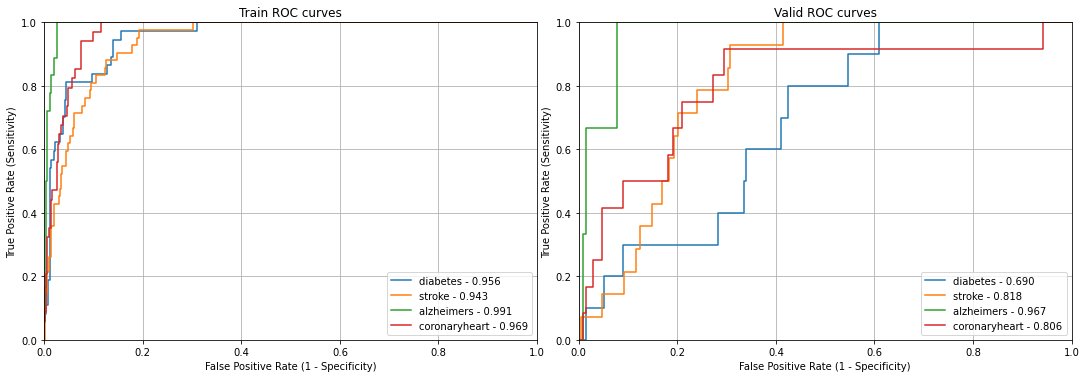

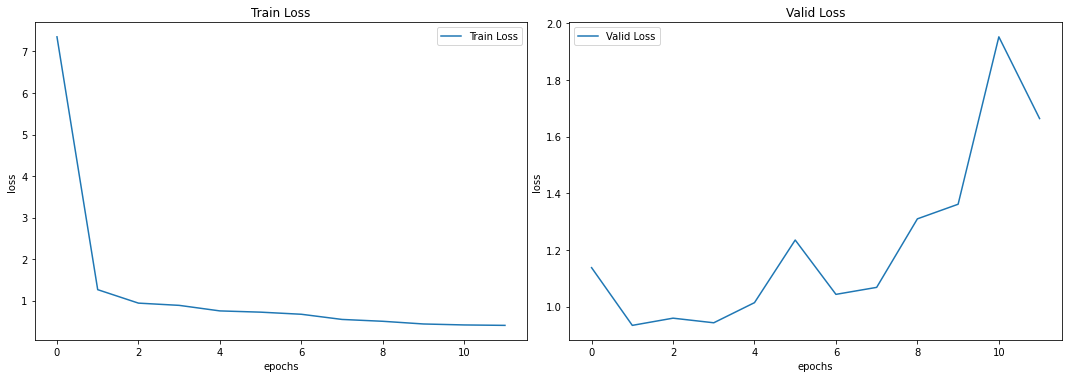

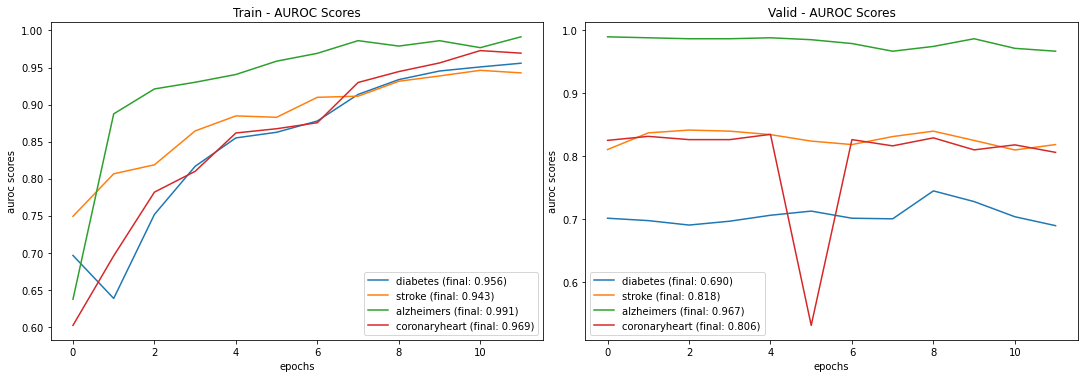

In [ ]:
plot_fit_results(h, LABELS)


Prediction Summary ...
               auroc_score  optimal_threshold     auroc_95_ci
diabetes          0.725962           0.195344  (0.611, 0.828)
stroke            0.826236           0.626417   (0.713, 0.92)
alzheimers        0.943779           0.369231     (0.9, 0.98)
coronaryheart     0.675535           0.314065  (0.426, 0.875)


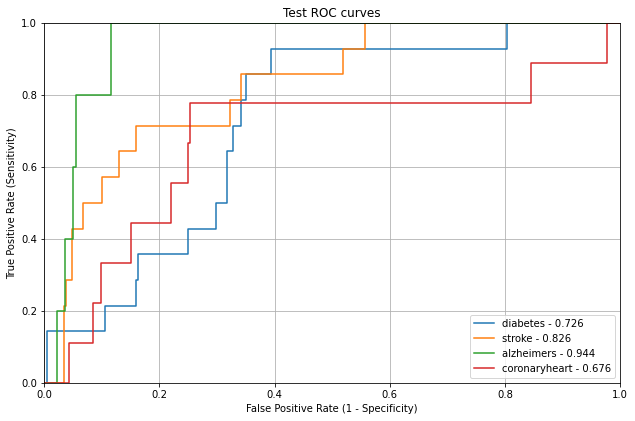

In [ ]:
h = summarize_prediction(h, LABELS)

In [ ]:
h.prediction_summary

,auroc_score,optimal_threshold,auroc_95_ci
diabetes,0.725962,0.195344,"(0.611, 0.828)"
stroke,0.826236,0.626417,"(0.713, 0.92)"
alzheimers,0.943779,0.369231,"(0.9, 0.98)"
coronaryheart,0.675535,0.314065,"(0.426, 0.875)"


## `EHR_CNN`

Based on the Deepr paper<br>
[Nguyen. et al. Deepr: A Convolutional Net for Medical Records](https://arxiv.org/abs/1607.07519)

**Sizes (+ Conv Arithmetic)**

- https://arxiv.org/pdf/1603.07285.pdf
- conv arithmetic - https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [ ]:
bs = 64 #batch size # of patients
wd = 85 #rec_emb_width (concat of 1 yr of records)
ht = 240 #num of years of pt data (seq_len or bptt in lstm)

**Each pt is a 20 by 85 matrix**
- 20 years on axis 0 (height)
- 85 codes on axis 1 (width)

In [ ]:
tst_pts = torch.randn(bs,ht,wd)

In [ ]:
tst_pts.shape

torch.Size([64, 240, 85])

But ...
- **Input ::** $(N, C_{in}, H_{in}, W_{in})$
- **Output::** $(N, C_{out}, H_{out}, W_{out})$

So need to reshape to insert $C_{in}$ (which is 1 in this case) after bs

In [ ]:
tst_pts = tst_pts.reshape(bs,1,ht,wd)
tst_pts.shape

torch.Size([64, 1, 240, 85])

In [ ]:
m = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(5,5), padding=2), nn.ReLU(),
    nn.Conv2d(2,4,kernel_size=(3,3), padding=1), nn.ReLU(),
    nn.Conv2d(4,8,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(8,16,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16,32,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveMaxPool2d((4,4)),
    nn.Flatten()
)

In [ ]:
out = m(tst_pts)

In [ ]:
out.shape

torch.Size([64, 512])

- AdaptivePool ensures output before Flatten is bs x 16 x 5 x 5
- And thus Flatten will always flatten it to bs x 400
- **So can use 400 safely** - no matter the size of the input (which will change based on vocab dims)

In [ ]:
for name, param in m.named_parameters():
    print(name)

0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
6.weight
6.bias
8.weight
8.bias


## Model

- Weight Init
    - Embedding weights = `uniform` with initrange
    - layer weights = `kaiming_normal`
- Conv 
    - kernel sizes = 3,5 then 5,7
    - filters = 2,4,8,16
- Linear layers = 3
- Optim = Adagrad with L2(weight decay)
- BatchNorm
- Dropout
    - ~~CNN dropout~~
    - Input dropput (fastai RNN dropout)
    - Linear dropout

In [ ]:
bn = True

In [ ]:
not bn

False

In [ ]:
#export
def init_cnn(m, initrange, zero_bn=False):
    '''Initialize CNN as described in fast.ai'''
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Embedding, nn.EmbeddingBag)): m.weight.data.uniform_(-initrange, initrange)
    if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)): nn.init.constant_(m.weight, 0. if zero_bn else 1.)
    for l in m.children(): init_cnn(l, initrange, zero_bn)

def conv_layer(in_channels, out_channels, kernel_size, stride=1, padding=1, bn=False):
    '''Create a single conv layer - as described in fast.ai'''
    layer = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not bn)]
    if bn: layer.append(nn.BatchNorm2d(out_channels))
    layer.append(nn.ReLU(inplace=True))
    return layer

Based on perf tuning recommendation.. 
- [Disabling bias for convolutions if directly followed by a batch norm](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#disable-bias-for-convolutions-directly-followed-by-a-batch-norm)

In [ ]:
#export
class EHR_CNN(nn.Module):
    '''Based on the model described in the Deepr paper - https://arxiv.org/abs/1607.07519'''
    def __init__(self, demograph_dims, rec_dims, demograph_wd, rec_wd, linear_layers=4, 
                 initrange=0.3, bn=False, input_drp=0.3, linear_drp=0.3, zero_bn=False):
        
        super().__init__()
        
        self.embs  = nn.ModuleList([nn.Embedding(*dim) for dim in demograph_dims])
        self.embgs = nn.ModuleList([nn.EmbeddingBag(*dim) for dim in rec_dims])
        
        self.rec_wd        = rec_wd      
        self.demograph_wd  = demograph_wd 
        self.bn            = bn
        lin_features_start = (demograph_wd + 1) + 512 #adding 1 for 'age_now', 512 = cnn output

        
        self.input_dp = InputDropout(input_drp)

        out, self.lin = create_linear_layers(lin_features_start, linear_layers, bn, linear_drp)
        self.lin_o    = nn.Linear(out, 4)     

        self.cnn = nn.Sequential(
        *conv_layer(in_channels=1, out_channels=2, kernel_size=(5,5), padding=2, bn=self.bn),
        *conv_layer(2,4,kernel_size=(3,3), padding=1, bn=self.bn),
        *conv_layer(4,8,kernel_size=3, stride=2, padding=1, bn=self.bn),
        *conv_layer(8,16,kernel_size=3, stride=2, padding=1, bn=self.bn),
        *conv_layer(16,32,kernel_size=3, stride=2, padding=1, bn=self.bn),
        nn.AdaptiveMaxPool2d((4,4)),
        nn.Flatten()
        )
        
        init_cnn(self, initrange, zero_bn)


    def get_embs(self, ptbatch_recs, ptbatch_demogs, x):
        for p in range(len(x)): #for the batch of pts
            ptbatch_recs[p] = torch.cat((self.embgs[0](x[p].obs_nums,x[p].obs_offsts), 
                                         self.embgs[1](x[p].alg_nums,x[p].alg_offsts),
                                         self.embgs[2](x[p].crpl_nums,x[p].crpl_offsts),
                                         self.embgs[3](x[p].med_nums,x[p].med_offsts),
                                         self.embgs[4](x[p].img_nums,x[p].img_offsts),
                                         self.embgs[5](x[p].proc_nums,x[p].proc_offsts),
                                         self.embgs[6](x[p].cnd_nums,x[p].cnd_offsts),
                                         self.embgs[7](x[p].imm_nums,x[p].imm_offsts)),
                                        dim=1) #for the entire age span, example all 20 yrs
            ptbatch_demogs[p] = torch.cat((self.embs[0](x[p].demographics[0]), 
                                           self.embs[1](x[p].demographics[1]),
                                           self.embs[2](x[p].demographics[2]),
                                           self.embs[3](x[p].demographics[3]),
                                           self.embs[4](x[p].demographics[4]),
                                           self.embs[5](x[p].demographics[5]),
                                           self.embs[6](x[p].demographics[6]),
                                           self.embs[7](x[p].demographics[7]),
                                           self.embs[8](x[p].demographics[8]),
                                           self.embs[9](x[p].demographics[9]),
                                           self.embs[10](x[p].demographics[10]),
                                           x[p].age_now)) 

        return ptbatch_recs, ptbatch_demogs
    
    def forward(self, x):
        
        bs     = len(x)
        height = len(x[0].obs_offsts)
        width  = self.rec_wd

        ptbatch_recs   = torch.empty(bs,height,width, device=DEVICE)
        ptbatch_demogs = torch.empty(bs,self.demograph_wd+1, device=DEVICE)
        
        ptbatch_recs, ptbatch_demogs = self.get_embs(ptbatch_recs, ptbatch_demogs, x)
        ptbatch_recs = self.input_dp(ptbatch_recs)                                    #apply input dropout
        
        res = self.cnn(ptbatch_recs.reshape(bs,1,height,width))                       #cnn output
        res   = self.lin(torch.cat((res, ptbatch_demogs), dim=1))                     #concat demographics + send thru linear lyrs
        out   = self.lin_o(res)
        
        return out

**Load Data + Inspect**

In [ ]:
ehr_1K_data = EHRData(PATH_1K, LABELS, age_start=240, age_stop=360, age_in_months=True, lazy_load_gpu=False) #entire dataset on GPU

In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(EhrVocabList.load(PATH_1K))

In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data()

**Inspect Model**

In [ ]:
model = EHR_CNN(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd)

In [ ]:
model

EHR_CNN(
  (embs): ModuleList(
    (0): Embedding(33, 8)
    (1): Embedding(14, 7)
    (2): Embedding(124, 11)
    (3): Embedding(5, 5)
    (4): Embedding(7, 6)
    (5): Embedding(25, 8)
    (6): Embedding(4, 5)
    (7): Embedding(205, 13)
    (8): Embedding(211, 13)
    (9): Embedding(3, 5)
    (10): Embedding(200, 13)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(550, 17, mode=mean)
    (1): EmbeddingBag(27, 8, mode=mean)
    (2): EmbeddingBag(54, 9, mode=mean)
    (3): EmbeddingBag(224, 13, mode=mean)
    (4): EmbeddingBag(11, 6, mode=mean)
    (5): EmbeddingBag(128, 12, mode=mean)
    (6): EmbeddingBag(201, 13, mode=mean)
    (7): EmbeddingBag(20, 7, mode=mean)
  )
  (input_dp): InputDropout()
  (lin): Sequential(
    (0): Linear(in_features=607, out_features=1214, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1214, out_features=2428, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6):

In [ ]:
# for name, param in model.named_parameters():
#     print(f'{name}::\n{param}')

### Test `fit()`

In [ ]:
train_loss_fn, valid_loss_fn = get_loss_fn(train_pos_wts), get_loss_fn(valid_pos_wts)

In [ ]:
model = EHR_CNN(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd).cuda() #.cuda() to be called before optim

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters())

In [ ]:
h = RunHistory(LABELS)

In [ ]:
%time h = fit(3, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path='./models', from_chkpt_path=None, verbosity=1)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |        239.016 | [0.535 0.651 0.669 0.592]              1.407 | [0.708 0.827 0.982 0.759]
    1 |          1.479 | [0.572 0.726 0.855 0.616]              1.059 | [0.679 0.837 0.994 0.792]
    2 |          1.060 | [0.721 0.843 0.929 0.714]              1.121 | [0.665 0.832 0.989 0.798]
Checkpointed to "./models/checkpoint.tar"
CPU times: user 7.37 s, sys: 701 ms, total: 8.07 s
Wall time: 8.25 s


In [ ]:
%time h = fit(2, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path='./models', from_chkpt_path='./models', verbosity=1)

From "./models/checkpoint.tar", loading model ...
loading optimizer and epoch_index ...
epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    3 |          1.018 | [0.695 0.801 0.948 0.766]              1.046 | [0.671 0.846 0.988 0.799]
    4 |          1.013 | [0.729 0.850 0.955 0.732]              0.911 | [0.671 0.828 0.986 0.795]
Checkpointed to "./models/checkpoint.tar"
CPU times: user 5.22 s, sys: 935 ms, total: 6.15 s
Wall time: 6.31 s


### Test `predict()`

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
len(test_dl), test_pos_wts

(2, tensor([15., 15., 43., 24.]))

In [ ]:
test_loss_fn = get_loss_fn(test_pos_wts)

In [ ]:
h = predict(h, model, test_loss_fn, auroc_score, test_dl, chkpt_path='./models')

From "./models/checkpoint.tar", loading model ...
test loss = 0.9240354597568512
test aurocs = [0.70364  0.893887 0.935484 0.81951 ]


### Test plotting + results

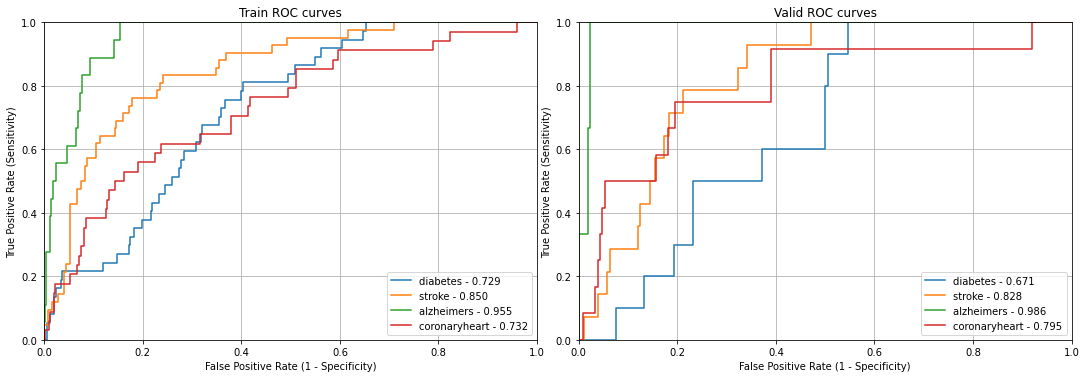

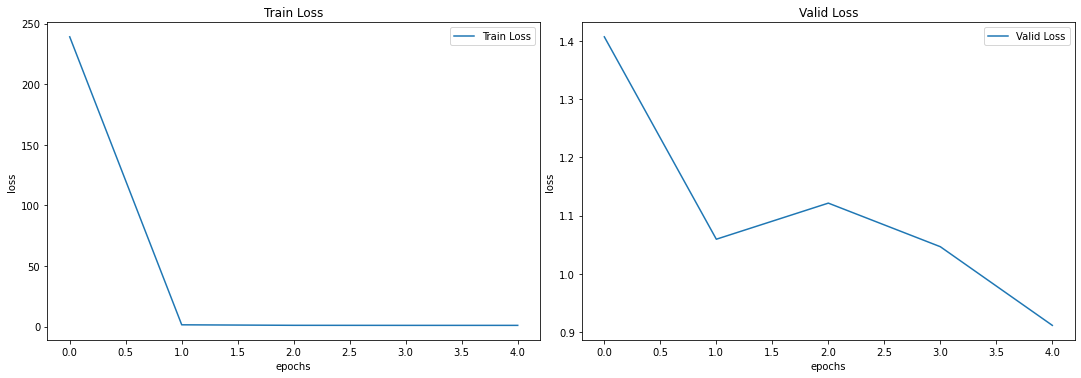

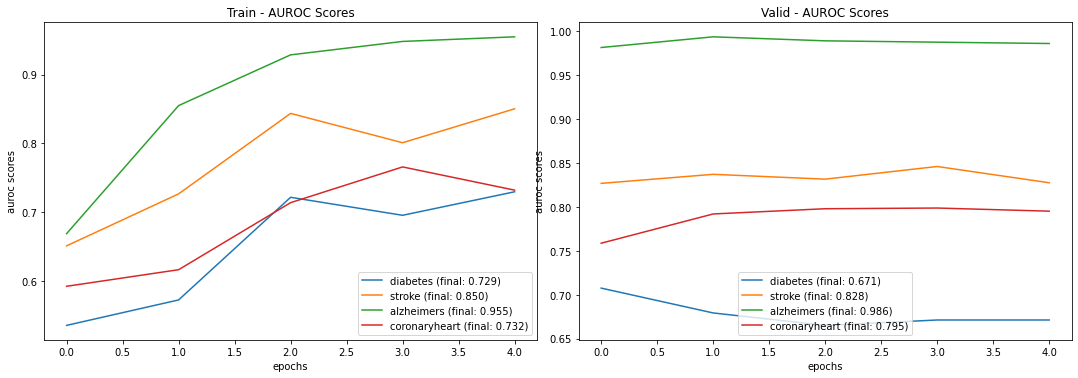

In [ ]:
plot_fit_results(h, LABELS)


Prediction Summary ...
               auroc_score  optimal_threshold     auroc_95_ci
diabetes          0.703640           0.610398   (0.583, 0.82)
stroke            0.893887           0.578268  (0.815, 0.955)
alzheimers        0.935484           0.549111  (0.893, 0.973)
coronaryheart     0.819510           0.537623    (0.6, 0.961)


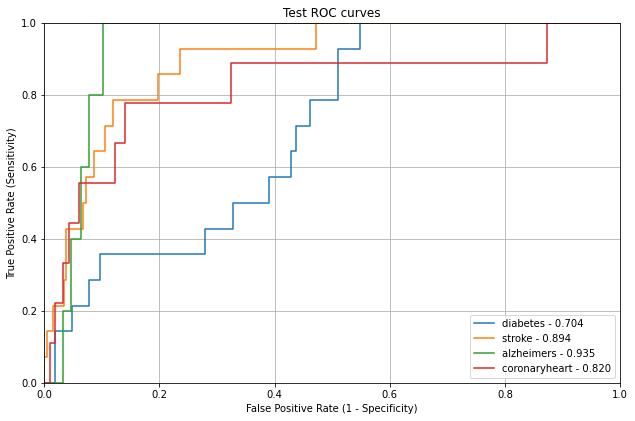

In [ ]:
h = summarize_prediction(h, LABELS)

In [ ]:
h.prediction_summary

,auroc_score,optimal_threshold,auroc_95_ci
diabetes,0.703640,0.610398,"(0.583, 0.82)"
stroke,0.893887,0.578268,"(0.815, 0.955)"
alzheimers,0.935484,0.549111,"(0.893, 0.973)"
coronaryheart,0.819510,0.537623,"(0.6, 0.961)"


## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_preprocessing_clean.ipynb.
Converted 02_preprocessing_vocab.ipynb.
Converted 03_preprocessing_transform.ipynb.
Converted 04_data.ipynb.
Converted 05_metrics.ipynb.
Converted 06_learn.ipynb.
Converted 07_models.ipynb.
Converted 08_experiment.ipynb.
Converted index.ipynb.
